## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    #size of conv kernel is 7*7*3, the number is 32
    #output_size:(32-7+1)/stride * (32-7+1)/stride * 32
    #if stride=2
    #13*13*32 = 5408
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    #13*13*32 -->  1*5408
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
"""""
tf.one_hot(indices, depth)
将输入转换为one_hot张量
label1:[0 1 2 3 4]
after one_hot:
[[1 0 0 0 0]
[0 1 0 0 0]
[0 0 1 0 0]
[0 0 0 1 0]
[0 0 0 0 1]]
"""""
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 8.68 and accuracy of 0.11
Iteration 100: with minibatch training loss = 0.897 and accuracy of 0.23
Iteration 200: with minibatch training loss = 0.921 and accuracy of 0.22
Iteration 300: with minibatch training loss = 0.587 and accuracy of 0.44
Iteration 400: with minibatch training loss = 0.494 and accuracy of 0.31
Iteration 500: with minibatch training loss = 0.568 and accuracy of 0.25
Iteration 600: with minibatch training loss = 0.476 and accuracy of 0.39
Iteration 700: with minibatch training loss = 0.498 and accuracy of 0.34
Epoch 1, Overall loss = 0.753 and accuracy of 0.306


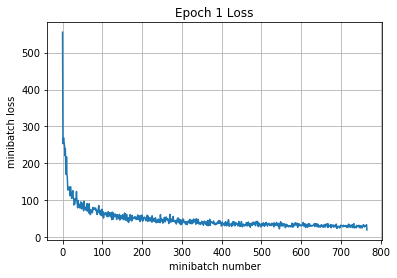

Validation
Epoch 1, Overall loss = 0.433 and accuracy of 0.371


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    #tf.argmax返回predict每行数值最大的下标
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    #tf.cast 将输入的数据格式转换为dtype
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        #math.ceil返回大于参量的最小整数
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            #最后一次迭代中，实际的batch_size可能会小于设定的batch_size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            
            #variables = [mean_loss,correct_prediction,accuracy]
            #mean_loss = tf.reduce_mean(total_loss)
            #correct_prediction = tf.equal(tf.argmax(predict,1), y)
            #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [5]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    #setup variables
    W_conv1 = tf.get_variable("W_conv1",shape=[7,7,3,32])
    b_conv1 = tf.get_variable("b_conv1",shape=[32])
    #(32 - 7 + 1)/1 = 26
    #after Max Pooling, it will be 13*13*32=5408
    W1 = tf.get_variable("W1", shape=[5408, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10])
    
    #define the graph
    conv1_out = tf.nn.conv2d(X, W_conv1, strides=[1, 1, 1, 1], padding='VALID') + b_conv1
    bn1 = tf.layers.batch_normalization(conv1_out, center=True, scale=True, training=is_training)
    relu_bn1 = tf.nn.relu(bn1)
    pool1 = tf.nn.max_pool(relu_bn1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv_flat = tf.reshape(pool1, [-1, 5408])
    affine = tf.matmul(conv_flat, W1) + b1
    bn2 = tf.layers.batch_normalization(affine, center=True, scale=True, training=is_training)
    relu_bn2 = tf.nn.relu(bn2)
    y_out = tf.matmul(relu_bn2, W2) + b2
    return y_out

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

13.1 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [7]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

13.5 ms ± 873 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [9]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None
total_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y,10), logits=y_out))

mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.RMSPropOptimizer(1e-3)

In [10]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [11]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 2.8 and accuracy of 0.16
Iteration 100: with minibatch training loss = 2.05 and accuracy of 0.34
Iteration 200: with minibatch training loss = 1.55 and accuracy of 0.42
Iteration 300: with minibatch training loss = 1.3 and accuracy of 0.53
Iteration 400: with minibatch training loss = 1.34 and accuracy of 0.47
Iteration 500: with minibatch training loss = 1.14 and accuracy of 0.58
Iteration 600: with minibatch training loss = 1.28 and accuracy of 0.55
Iteration 700: with minibatch training loss = 1.21 and accuracy of 0.62
Epoch 1, Overall loss = 1.51 and accuracy of 0.477


(1.5069688331253674, 0.477265306122449)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [12]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.14 and accuracy of 0.606


(1.1428003091812133, 0.60599999999999998)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

In [33]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    conv11 = tf.nn.conv2d(X, Wconv11, strides=[1,1,1,1],padding='SAME') + bconv11
    h11 = tf.nn.relu(conv11)
    conv12 = tf.nn.conv2d(h11, Wconv12, strides=[1,1,1,1],padding='SAME') + bconv12
    h12 = tf.nn.relu(conv12)
    conv13 = tf.nn.conv2d(h12, Wconv13, strides=[1,1,1,1],padding='SAME') + bconv13
    h_batch1 = tf.layers.batch_normalization(conv13, training=is_training)
    h1 = tf.nn.relu(h_batch1)
    h_pool1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print("h_pool1",h_pool1.shape)
    
    conv21 = tf.nn.conv2d(h_pool1, Wconv21, strides=[1, 1, 1, 1], padding='SAME') + bconv21
    h21 = tf.nn.relu(conv21)
    conv22 = tf.nn.conv2d(h21, Wconv22, strides=[1,1,1,1], padding='SAME') + bconv22
    h22 = tf.nn.relu(conv22)
    conv23 = tf.nn.conv2d(h22, Wconv23, strides=[1,1,1,1], padding='SAME') + bconv23
    h_batch23 = tf.layers.batch_normalization(conv23, training=is_training)
    h2 = tf.nn.relu(h_batch23)
    h_pool2 = tf.nn.max_pool(h2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')
    print("h_pool2",h_pool2.shape)
    
    conv31 = tf.nn.conv2d(h_pool2, Wconv31, strides=[1,1,1,1],padding='SAME') + bconv31
    h31 = tf.nn.relu(conv31)
    conv32 = tf.nn.conv2d(h31, Wconv32, strides=[1,1,1,1], padding='SAME') + bconv32
    h32 = tf.nn.relu(conv32)
    conv33 = tf.nn.conv2d(h32, Wconv33, strides=[1,1,1,1], padding='SAME') + bconv33
    h_batch3 = tf.layers.batch_normalization(conv33, training=is_training)
    h3 = tf.nn.relu(h_batch3)
    print("h3",h3.shape)
    h_pool3 = tf.nn.max_pool(h3, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')
    print("h_pool3",h_pool3.shape)
    
    conv_flat = tf.reshape(h_pool3, [-1,80])
    affine = tf.matmul(conv_flat, W1) + b1
    h_batch4 = tf.layers.batch_normalization(affine, training=is_training)
    h4 = tf.nn.relu(h_batch4)
    y_out = tf.matmul(h4, W2) + b2
    return y_out
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
global_step = tf.Variable(0)

Wconv11 = tf.get_variable("Wconv11", shape=[3, 3, 3, 30])
bconv11 = tf.get_variable("bconv11", [30])
Wconv12 = tf.get_variable("Wconv12", shape=[3, 3, 30, 30])
bconv12 = tf.get_variable("bconv12", [30])
Wconv13 = tf.get_variable("Wconv13", shape=[3, 3, 30, 30])
bconv13 = tf.get_variable("bconv13", [30])
#16*16*30

Wconv21 = tf.get_variable("Wconv21", shape=[3, 3, 30, 50])
bconv21 = tf.get_variable("bconv21", [50])
Wconv22 = tf.get_variable("Wconv22", shape=[3, 3, 50, 50])
bconv22 = tf.get_variable("bconv22", [50])
Wconv23 = tf.get_variable("Wconv23", shape=[3, 3, 50, 50])
bconv23 = tf.get_variable("bconv23", [50])
#4*4*50

Wconv31 = tf.get_variable("Wconv31", shape=[3, 3, 50, 80])
bconv31 = tf.get_variable("bconv31", [80])
Wconv32 = tf.get_variable("Wconv32", shape=[3, 3, 80, 80])
bconv32 = tf.get_variable("bconv32", [80])
Wconv33 = tf.get_variable("Wconv33", shape=[3, 3, 80, 80])
bconv33 = tf.get_variable("bconv33", [80])
#1*1*80

W1 = tf.get_variable("W1", shape=[80, 512])
b1 = tf.get_variable("b1", shape=[512])
W2 = tf.get_variable("W2", shape=[512, 10])
b2 = tf.get_variable("b2", shape=[10])
y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10),logits=y_out))
mean_loss += 0.001 * (tf.nn.l2_loss(Wconv11) + tf.nn.l2_loss(Wconv12) + tf.nn.l2_loss(Wconv13) + 
                      tf.nn.l2_loss(Wconv21) + tf.nn.l2_loss(Wconv22) + tf.nn.l2_loss(Wconv23) + 
                      tf.nn.l2_loss(Wconv31) + tf.nn.l2_loss(Wconv32) + tf.nn.l2_loss(Wconv33) + 
                      tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))
#tf.train..exponential_decay() 指数衰减学习率,每迭代100次学习率衰减为0.9倍
#decayed_learning_rate = learning_rate * decay_rate^(global_step/decay_steps)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 100, 0.9, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

h_pool1 (?, 16, 16, 30)
h_pool2 (?, 4, 4, 50)
h3 (?, 4, 4, 80)
h_pool3 (?, 1, 1, 80)


Training
Iteration 0: with minibatch training loss = 2.92 and accuracy of 0.14
Iteration 100: with minibatch training loss = 1.85 and accuracy of 0.39
Iteration 200: with minibatch training loss = 1.78 and accuracy of 0.45
Iteration 300: with minibatch training loss = 1.63 and accuracy of 0.56
Iteration 400: with minibatch training loss = 1.24 and accuracy of 0.67
Iteration 500: with minibatch training loss = 1.26 and accuracy of 0.62
Iteration 600: with minibatch training loss = 1.54 and accuracy of 0.5
Iteration 700: with minibatch training loss = 1.52 and accuracy of 0.55
Epoch 1, Overall loss = 1.55 and accuracy of 0.533


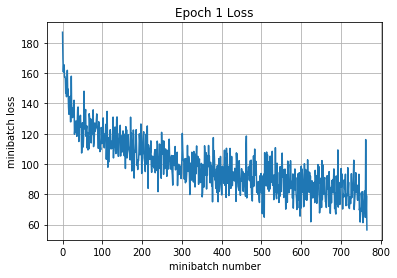

Iteration 800: with minibatch training loss = 0.972 and accuracy of 0.75
Iteration 900: with minibatch training loss = 1.11 and accuracy of 0.64
Iteration 1000: with minibatch training loss = 1.29 and accuracy of 0.67
Iteration 1100: with minibatch training loss = 1.29 and accuracy of 0.64
Iteration 1200: with minibatch training loss = 1.1 and accuracy of 0.73
Iteration 1300: with minibatch training loss = 1.08 and accuracy of 0.66
Iteration 1400: with minibatch training loss = 0.958 and accuracy of 0.77
Iteration 1500: with minibatch training loss = 0.908 and accuracy of 0.75
Epoch 2, Overall loss = 1.13 and accuracy of 0.675


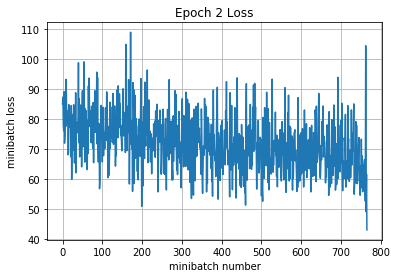

Iteration 1600: with minibatch training loss = 1.02 and accuracy of 0.75
Iteration 1700: with minibatch training loss = 0.802 and accuracy of 0.72
Iteration 1800: with minibatch training loss = 1.16 and accuracy of 0.62
Iteration 1900: with minibatch training loss = 1 and accuracy of 0.75
Iteration 2000: with minibatch training loss = 1.01 and accuracy of 0.7
Iteration 2100: with minibatch training loss = 1.27 and accuracy of 0.66
Iteration 2200: with minibatch training loss = 1.06 and accuracy of 0.66
Epoch 3, Overall loss = 0.983 and accuracy of 0.721


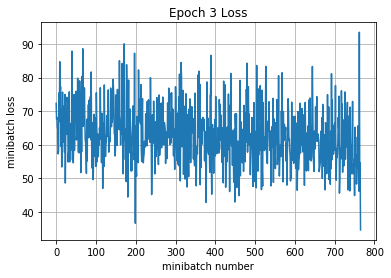

Iteration 2300: with minibatch training loss = 0.967 and accuracy of 0.72
Iteration 2400: with minibatch training loss = 0.922 and accuracy of 0.77
Iteration 2500: with minibatch training loss = 0.791 and accuracy of 0.77
Iteration 2600: with minibatch training loss = 0.768 and accuracy of 0.78
Iteration 2700: with minibatch training loss = 0.928 and accuracy of 0.73
Iteration 2800: with minibatch training loss = 0.652 and accuracy of 0.83
Iteration 2900: with minibatch training loss = 0.745 and accuracy of 0.83
Iteration 3000: with minibatch training loss = 1.07 and accuracy of 0.67
Epoch 4, Overall loss = 0.898 and accuracy of 0.753


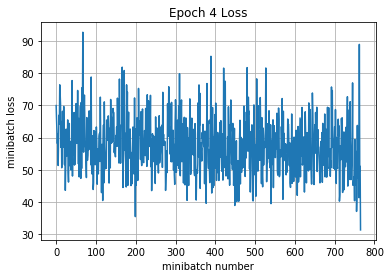

Iteration 3100: with minibatch training loss = 0.927 and accuracy of 0.75
Iteration 3200: with minibatch training loss = 0.728 and accuracy of 0.83
Iteration 3300: with minibatch training loss = 0.772 and accuracy of 0.77
Iteration 3400: with minibatch training loss = 1.13 and accuracy of 0.7
Iteration 3500: with minibatch training loss = 0.591 and accuracy of 0.89
Iteration 3600: with minibatch training loss = 0.849 and accuracy of 0.77
Iteration 3700: with minibatch training loss = 0.82 and accuracy of 0.8
Iteration 3800: with minibatch training loss = 0.793 and accuracy of 0.84
Epoch 5, Overall loss = 0.848 and accuracy of 0.77


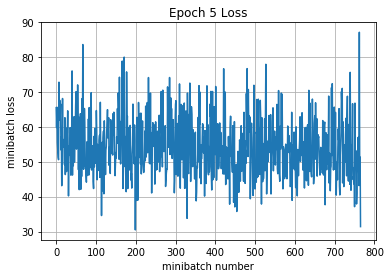

Iteration 3900: with minibatch training loss = 0.953 and accuracy of 0.66
Iteration 4000: with minibatch training loss = 0.786 and accuracy of 0.81
Iteration 4100: with minibatch training loss = 0.859 and accuracy of 0.81
Iteration 4200: with minibatch training loss = 0.719 and accuracy of 0.83
Iteration 4300: with minibatch training loss = 0.697 and accuracy of 0.78
Iteration 4400: with minibatch training loss = 0.606 and accuracy of 0.86
Iteration 4500: with minibatch training loss = 0.988 and accuracy of 0.73
Epoch 6, Overall loss = 0.808 and accuracy of 0.787


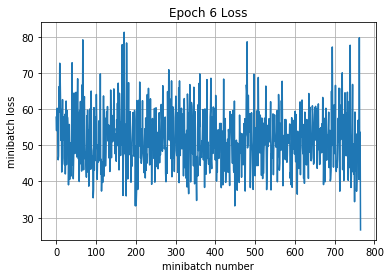

Iteration 4600: with minibatch training loss = 0.804 and accuracy of 0.78
Iteration 4700: with minibatch training loss = 0.782 and accuracy of 0.86
Iteration 4800: with minibatch training loss = 0.834 and accuracy of 0.78
Iteration 4900: with minibatch training loss = 0.641 and accuracy of 0.86
Iteration 5000: with minibatch training loss = 0.85 and accuracy of 0.86
Iteration 5100: with minibatch training loss = 1.03 and accuracy of 0.7
Iteration 5200: with minibatch training loss = 0.681 and accuracy of 0.83
Iteration 5300: with minibatch training loss = 0.684 and accuracy of 0.86
Epoch 7, Overall loss = 0.776 and accuracy of 0.803


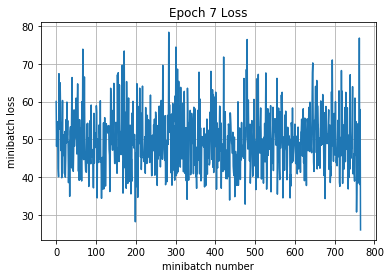

Iteration 5400: with minibatch training loss = 0.816 and accuracy of 0.78
Iteration 5500: with minibatch training loss = 0.818 and accuracy of 0.86
Iteration 5600: with minibatch training loss = 0.688 and accuracy of 0.83
Iteration 5700: with minibatch training loss = 0.588 and accuracy of 0.91
Iteration 5800: with minibatch training loss = 0.818 and accuracy of 0.81
Iteration 5900: with minibatch training loss = 0.814 and accuracy of 0.83
Iteration 6000: with minibatch training loss = 0.863 and accuracy of 0.8
Iteration 6100: with minibatch training loss = 0.678 and accuracy of 0.81
Epoch 8, Overall loss = 0.747 and accuracy of 0.812


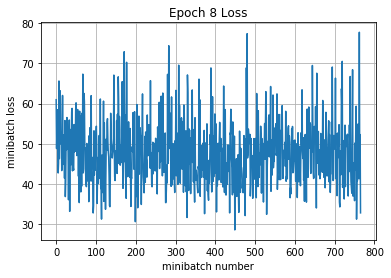

Iteration 6200: with minibatch training loss = 0.767 and accuracy of 0.8
Iteration 6300: with minibatch training loss = 0.829 and accuracy of 0.83
Iteration 6400: with minibatch training loss = 0.639 and accuracy of 0.86
Iteration 6500: with minibatch training loss = 0.741 and accuracy of 0.86
Iteration 6600: with minibatch training loss = 0.907 and accuracy of 0.77
Iteration 6700: with minibatch training loss = 0.799 and accuracy of 0.84
Iteration 6800: with minibatch training loss = 0.583 and accuracy of 0.89
Epoch 9, Overall loss = 0.721 and accuracy of 0.825


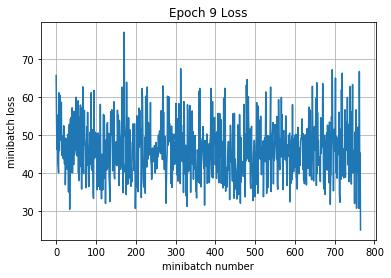

Iteration 6900: with minibatch training loss = 0.617 and accuracy of 0.88
Iteration 7000: with minibatch training loss = 0.621 and accuracy of 0.84
Iteration 7100: with minibatch training loss = 0.544 and accuracy of 0.92
Iteration 7200: with minibatch training loss = 0.689 and accuracy of 0.84
Iteration 7300: with minibatch training loss = 0.713 and accuracy of 0.81
Iteration 7400: with minibatch training loss = 0.701 and accuracy of 0.86
Iteration 7500: with minibatch training loss = 0.564 and accuracy of 0.91
Iteration 7600: with minibatch training loss = 0.611 and accuracy of 0.8
Epoch 10, Overall loss = 0.705 and accuracy of 0.833


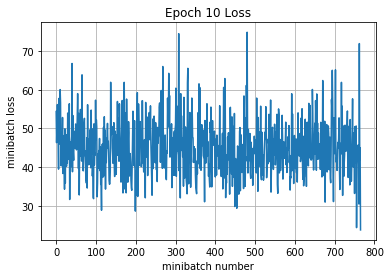

Validation
Epoch 1, Overall loss = 1.14 and accuracy of 0.731


In [34]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()
with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
    print('Validation')
    run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [35]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,128)

Test
Epoch 1, Overall loss = 1.23 and accuracy of 0.706


(1.2315358820915223, 0.7056)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [36]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.23 and accuracy of 0.706


(1.2315358820915223, 0.7056)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.